In [1]:
import sys
sys.path.insert(1,'/home/bwhiteak/exESN/ESN_utils/')
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

import ESN_util.rc_tools as rct

from itertools import chain 
from torchviz import make_dot, make_dot_from_trace

import torch
from torch import nn, Tensor, optim
from torch.nn.parameter import Parameter
import pdb 
from jupyterthemes import jtplot
jtplot.style()

def grad_printer(model: nn.Module) -> nn.Module:
    for parameter in model.parameters():
        parameter.register_hook(lambda grad: print(f'{grad}'))
    return model

In [2]:
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import optim
DEV = 'cuda:5'
DTYPE = torch.float32 

In [3]:
K = 1
N = 3
L = 1
TRAIN = 14000

In [4]:

class Leaky_Tanh(nn.Module):
    def __init__(self, N):
        """
        Initialize learnable parameters:
        alpha = controls influence of past information
        gamma = controls amplitude from nonlinear term
        """
        super(Leaky_Tanh,self).__init__()
        self.a = Parameter(torch.mul(torch.ones(1,N),.5))
        self.g = Parameter(torch.rand(1,N))
        self.aGrad_list = []
        self.gGrad_list = []
        
    def forward(self, x, z):
        self.a.register_hook(lambda x: self.aGrad_list.append(x.data))
        self.g.register_hook(lambda x: self.gGrad_list.append(x.data))
        return (1-self.a)*x + self.a*self.g*torch.tanh(x+z)
    
class SymESN(nn.Module):
    def __init__(self, k, n, l, r, rho):
        super(SymESN, self).__init__()

        self.N = n
        self.Q, self.d, self.Qt = self.initRes(r, rho)
        self.D = Parameter(self.d)
        self.Rin = nn.Linear(k, self.N, bias=False)
        #self.Res = nn.Linear(self.N,self.N, bias=False)
        self.Lky = Leaky_Tanh(self.N)
        self.Rout = nn.Linear(self.N+k,l, bias=False)
        self.sr_list = []

    def forward(self, hidden, ut):
        self.D.register_hook(lambda x: self.sr_list.append(x.data)) # Gradient
        z = self.Rin(ut)
        ht = torch.matmul(hidden,torch.matmul(self.Q, torch.matmul(torch.diag(self.D), self.Qt)))#self.Res(hidden)
        ht1 = self.Lky(ht,z)
        output = self.Rout(torch.cat((ht1,ut),1))
        return ht1, output

    def packState(self, h=None):
        if(not h):
            h = torch.randn(1, self.N)
        else:
            h = h.detach_()
        return h
    def initRes(self, r, rho):
        A = torch.mul(torch.sub(torch.rand((self.N,self.N)),.5),2.)
        W = (A + torch.transpose(A,0,1))-torch.diag(torch.diagonal(A))
        eigmax = torch.max(torch.abs(torch.linalg.eigvals(W)))
        Wszd = torch.mul(torch.div(W,eigmax),rho)
        D,Q = torch.linalg.eig(Wszd)
        return torch.real(Q), torch.real(D), torch.real(torch.transpose(Q,0,1))
    
    def clearList(self):
        self.Lky.aGrad_list = []
        self.Lky.gGrad_list = []
        self.sr_list = []


esn = SymESN(K,N,L,1.0,.6)
print(esn)
for n,p in esn.named_parameters():
    print(n)

SymESN(
  (Rin): Linear(in_features=1, out_features=3, bias=False)
  (Lky): Leaky_Tanh()
  (Rout): Linear(in_features=4, out_features=1, bias=False)
)
D
Rin.weight
Lky.a
Lky.g
Rout.weight


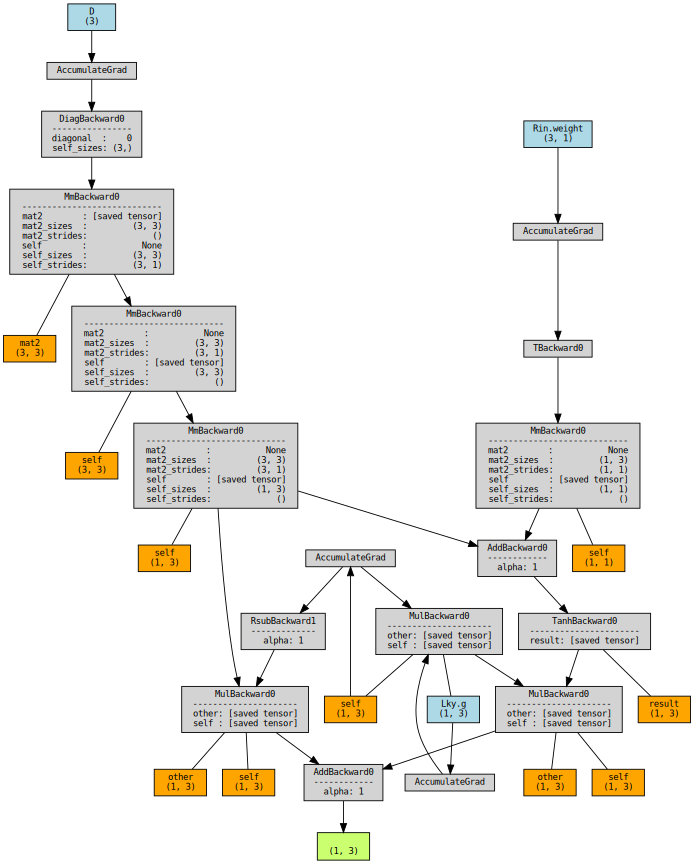

In [5]:
ut = torch.Tensor([[1]])
xt = esn.packState()
xt1, yhat = esn(xt,ut)
make_dot(xt1, params=dict(esn.named_parameters()), show_attrs=True, show_saved=True)

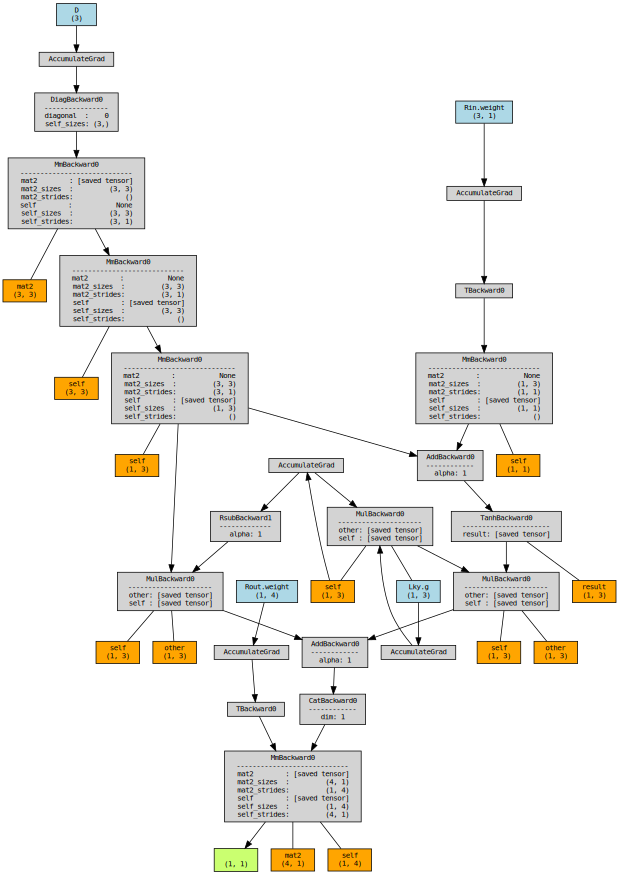

In [6]:
make_dot(yhat, params=dict(esn.named_parameters()), show_attrs=True, show_saved=True)

In [7]:
FREERUN = 20
DT = .02

rho = 28.0
sigma = 10.0
beta = 8/3

def f(state, t):
    x,y,z = state
    return sigma*(y-x), x*(rho-z)-y, x*y - beta*z

state0 = [1.,1.,1.]
t = np.arange(0,300+FREERUN,DT)
states = odeint(f,state0,t)
Tl = TRAIN
muX = np.mean(states[:,0])
signal = states[:Tl,0]-muX

In [8]:
criterion = nn.MSELoss()
optimizer = optim.Adam(esn.parameters(),lr=.05)

Epoch: 0


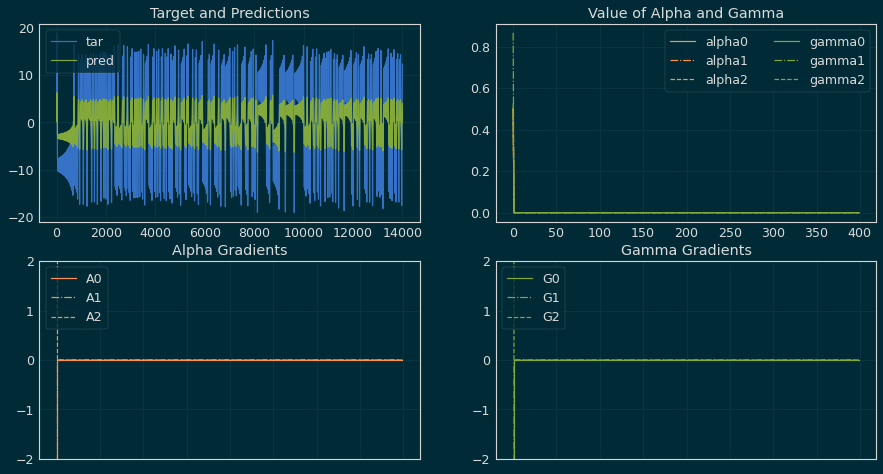

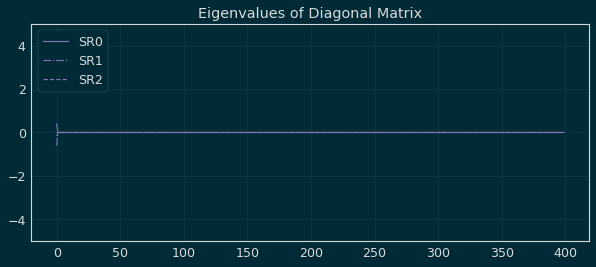

Epoch: 10


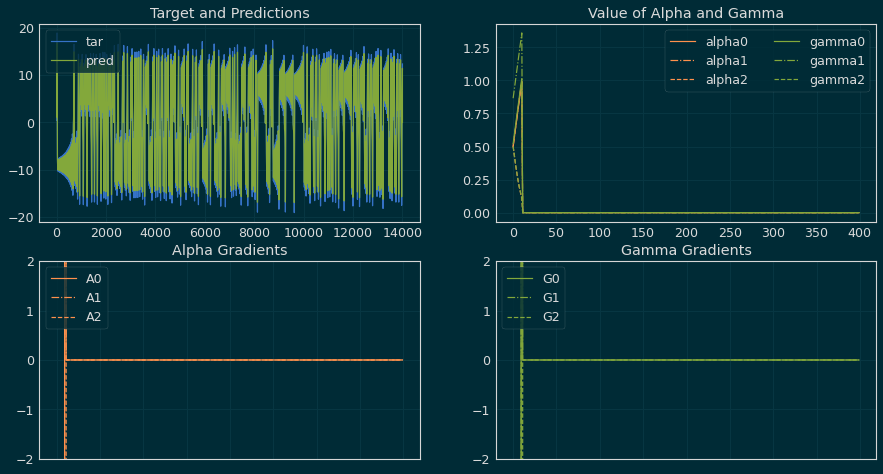

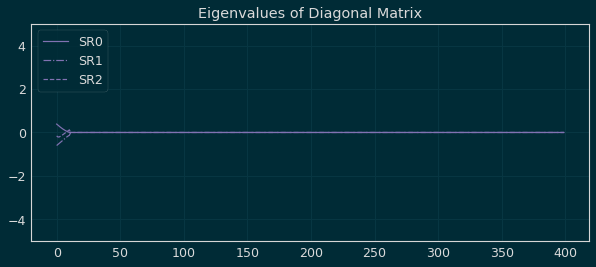

Epoch: 20


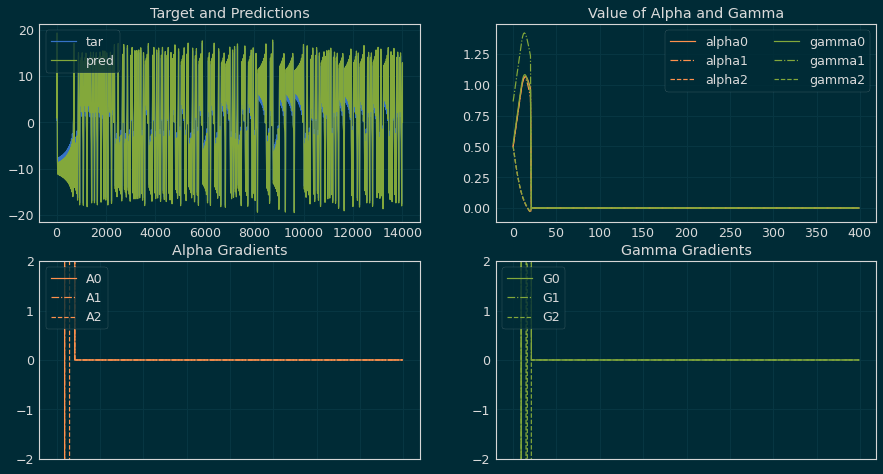

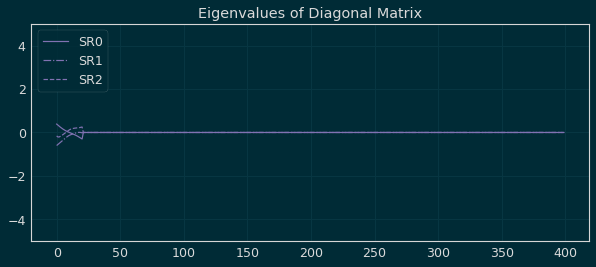

Epoch: 30


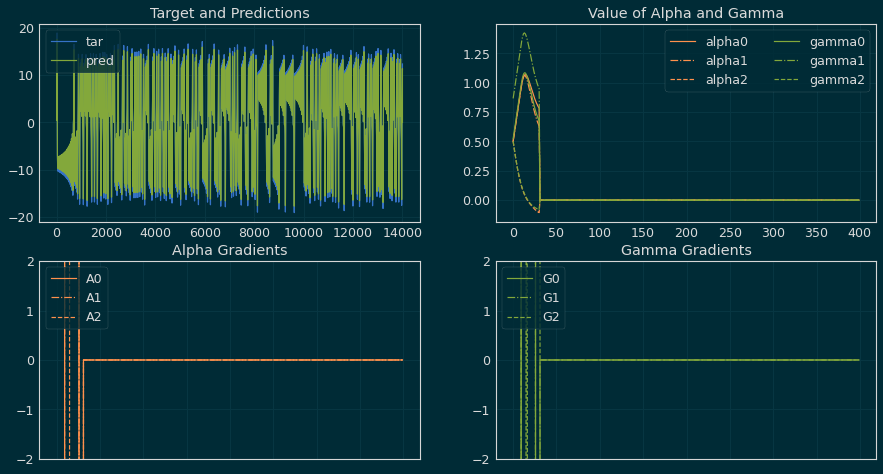

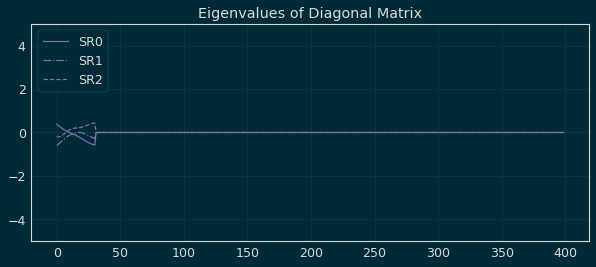

Epoch: 40


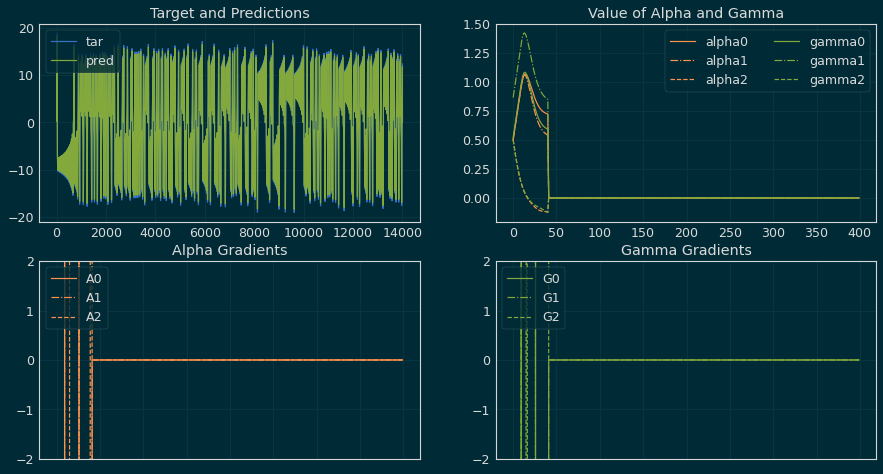

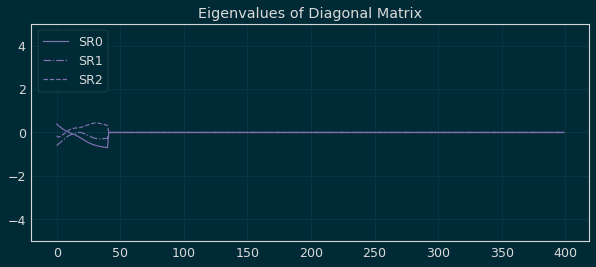

Epoch: 50


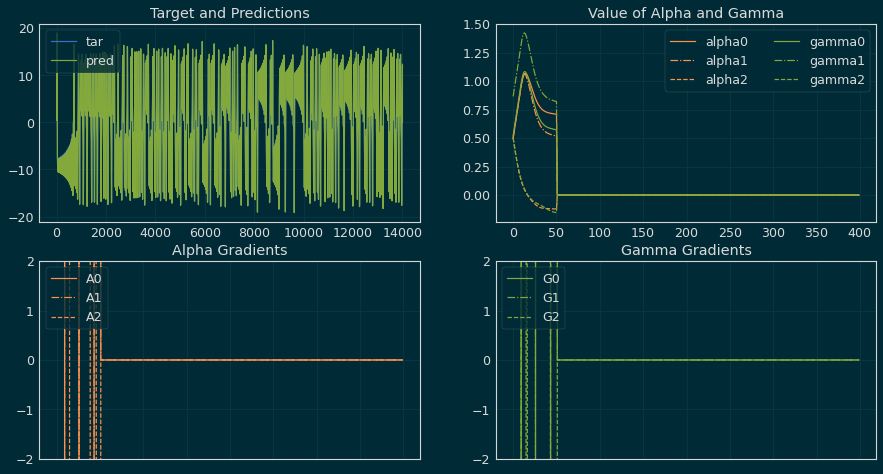

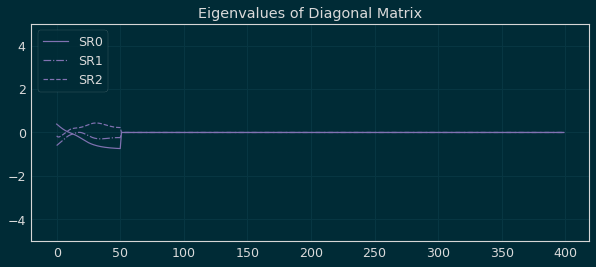

Epoch: 60


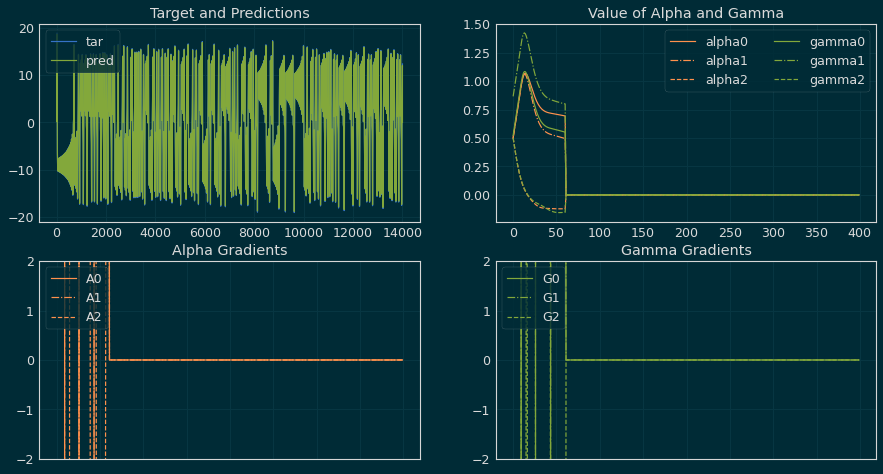

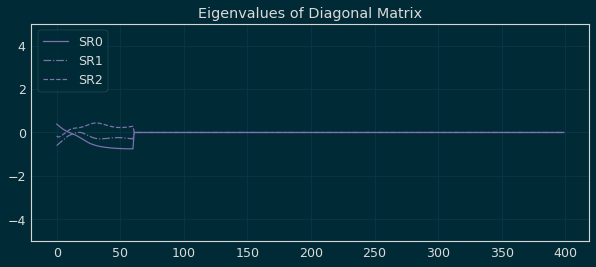

Epoch: 70


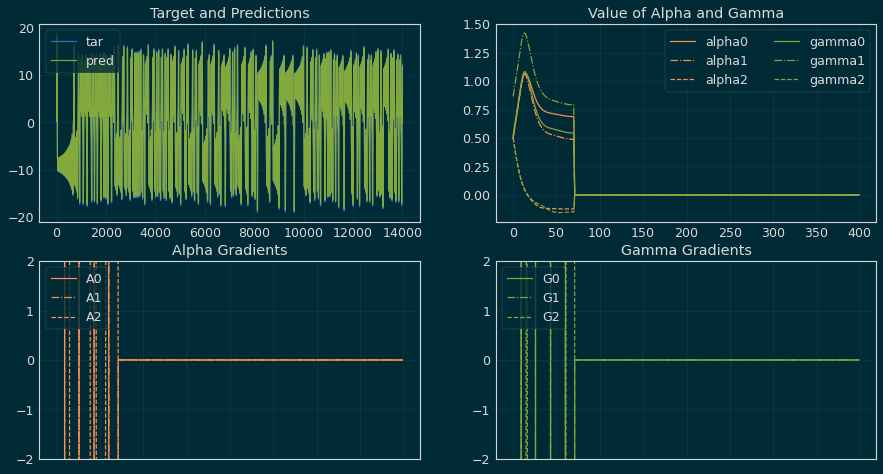

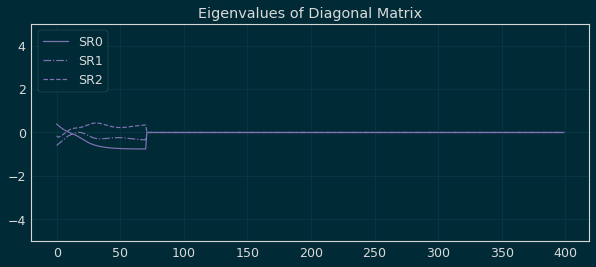

Epoch: 80


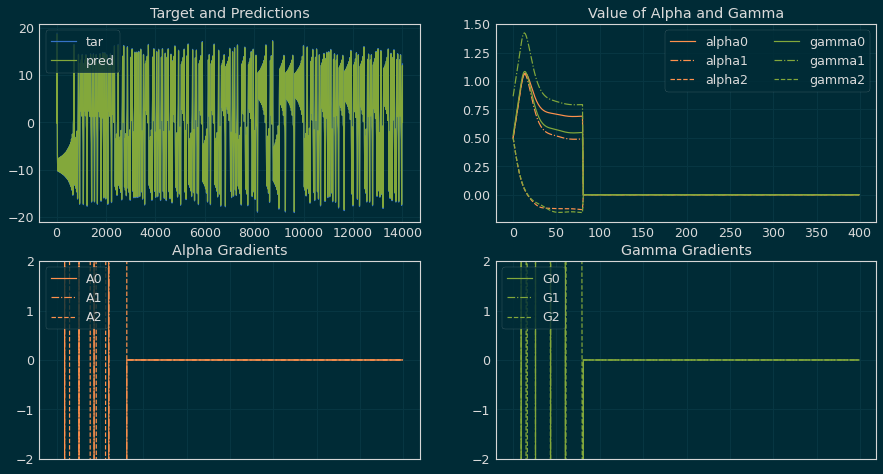

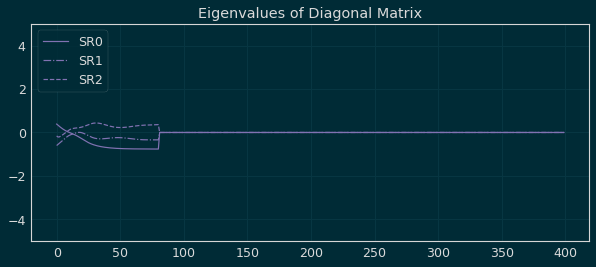

Epoch: 90


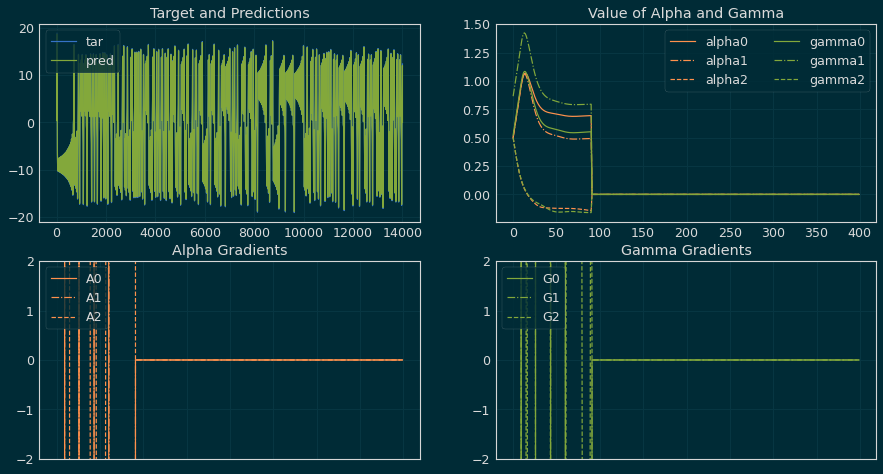

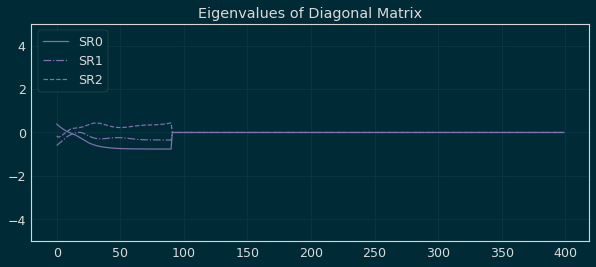

Epoch: 100


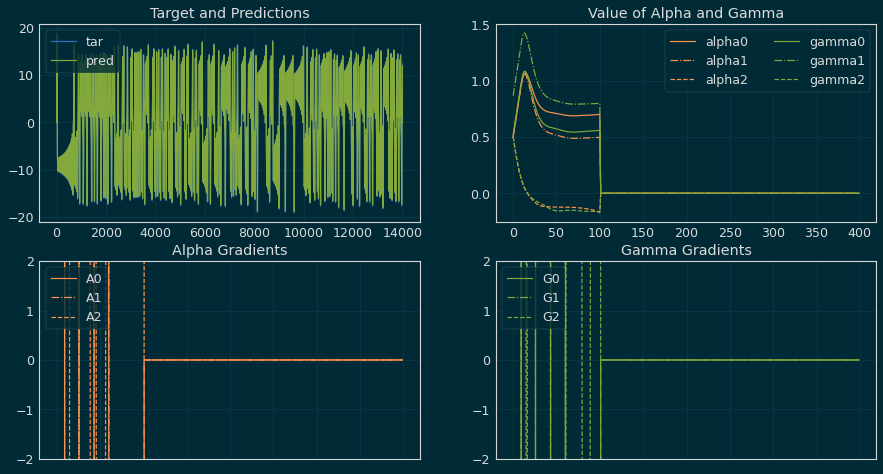

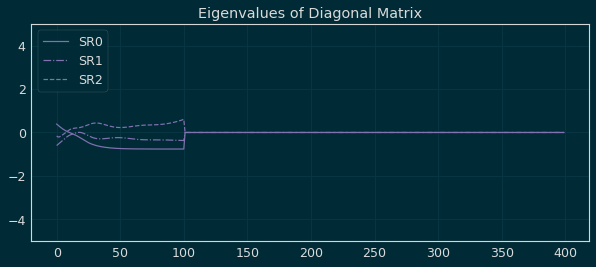

Epoch: 110


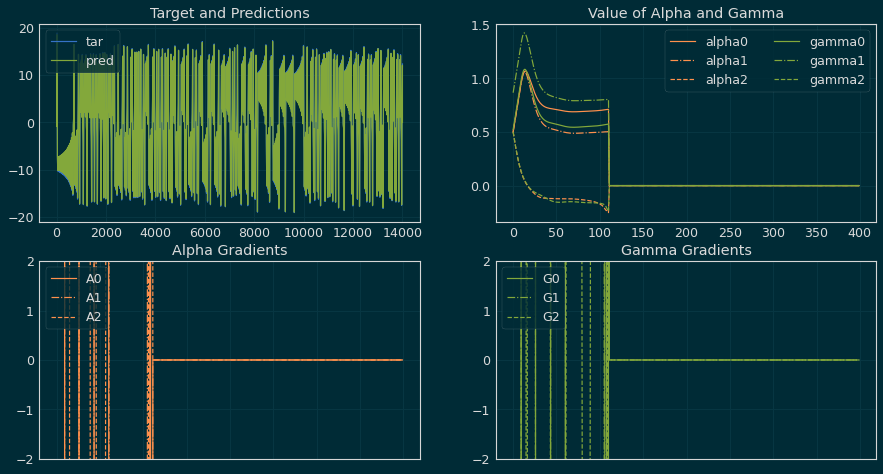

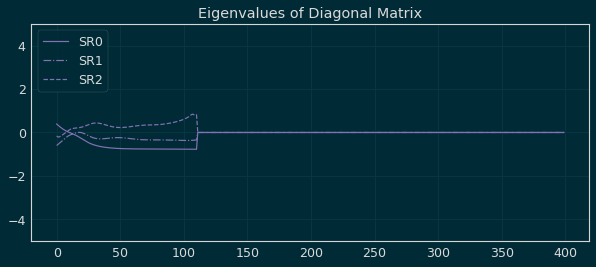

Epoch: 120


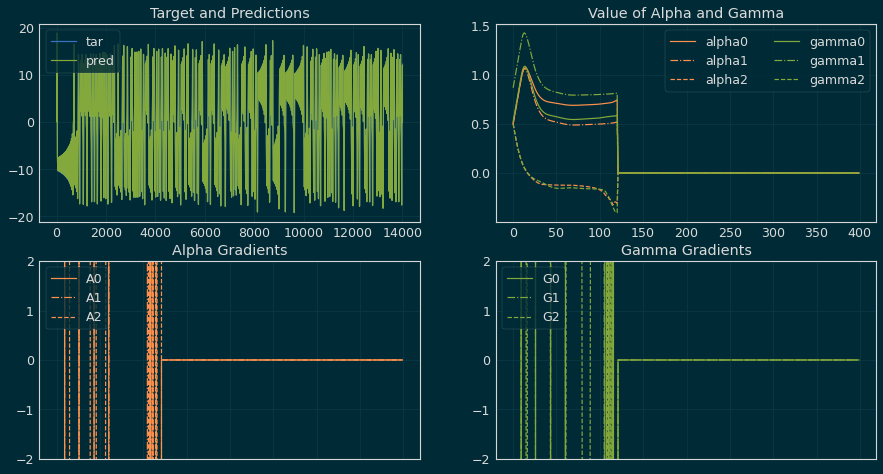

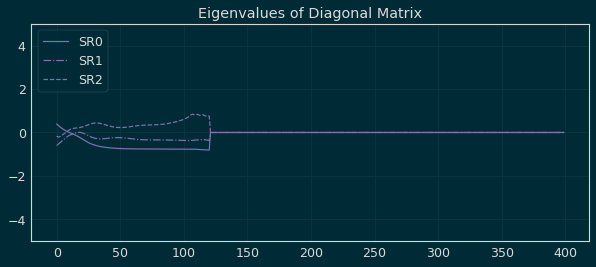

Epoch: 130


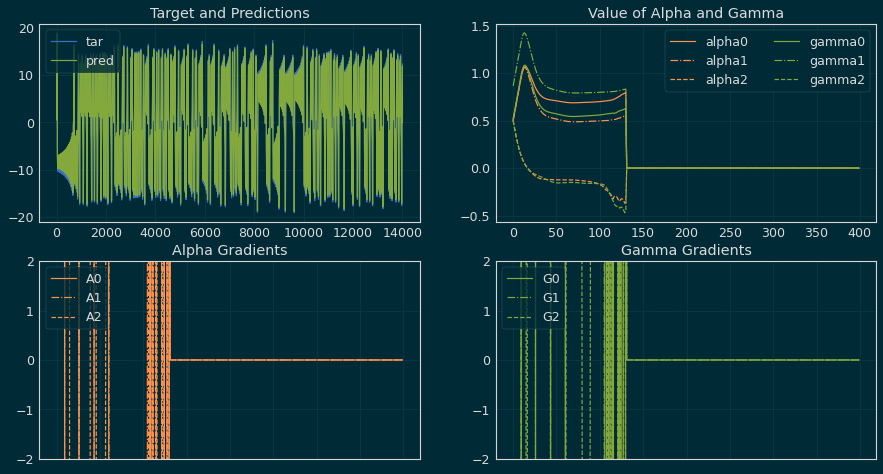

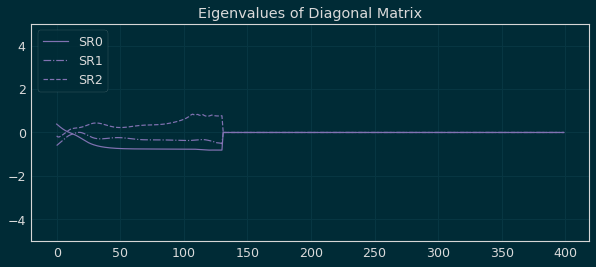

Epoch: 140


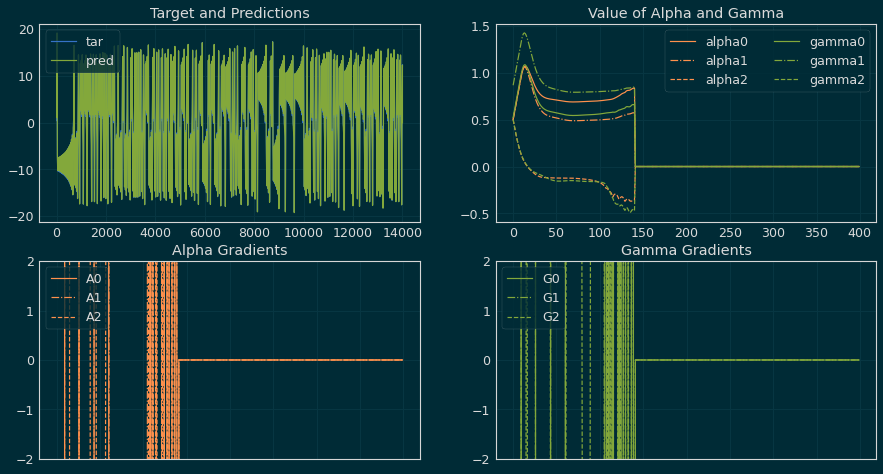

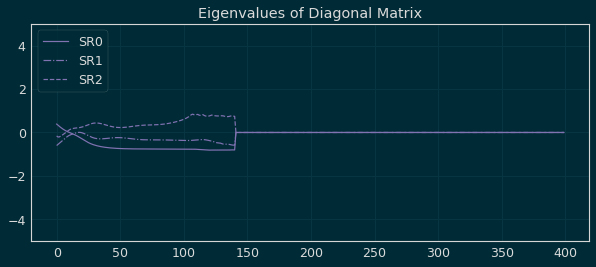

Epoch: 150


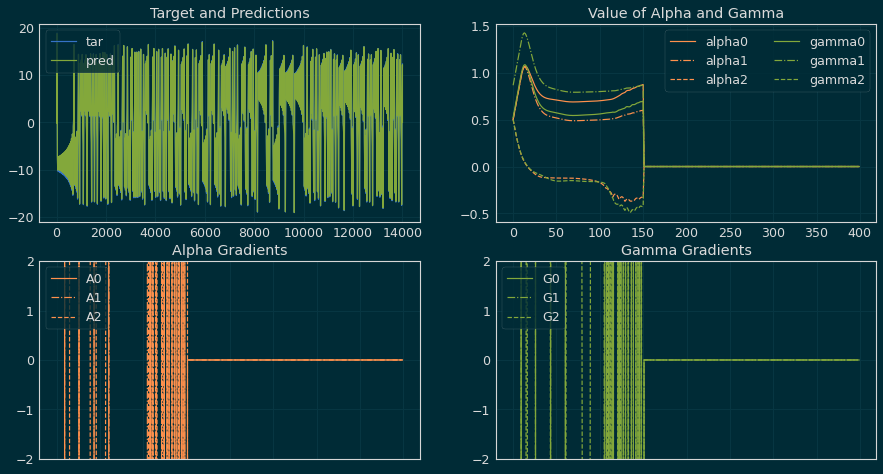

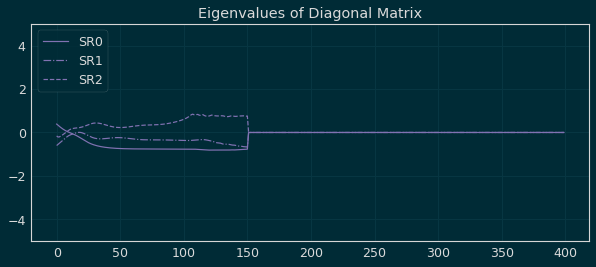

Epoch: 160


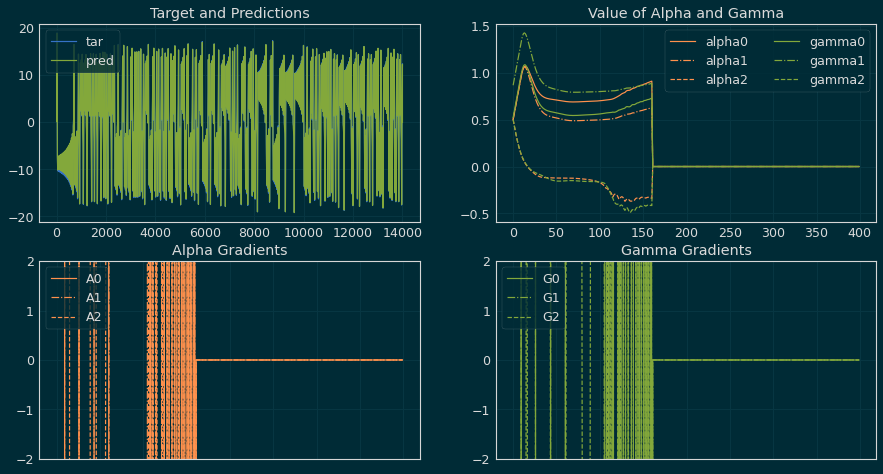

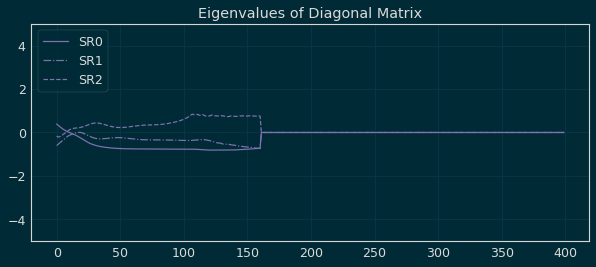

Epoch: 170


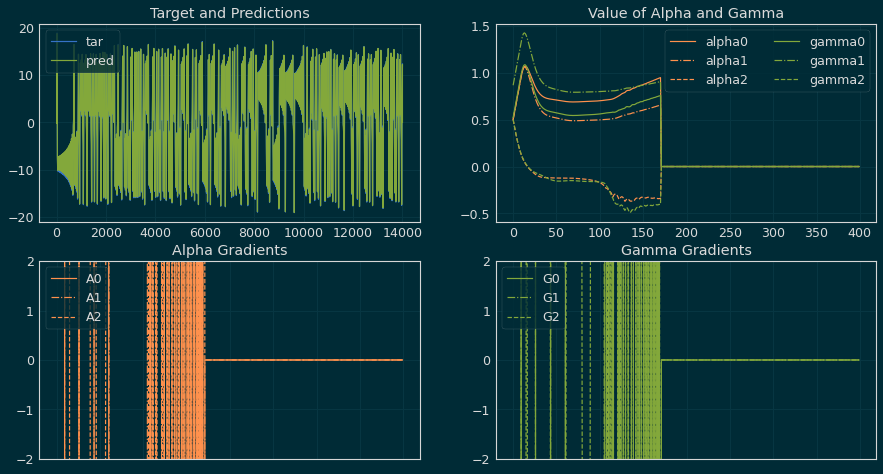

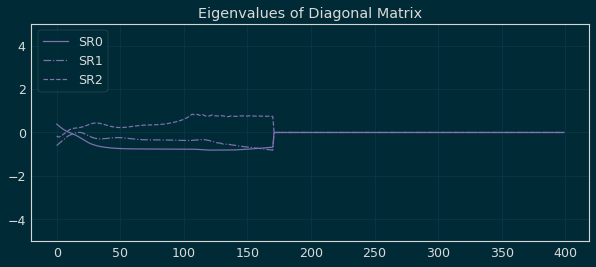

Epoch: 180


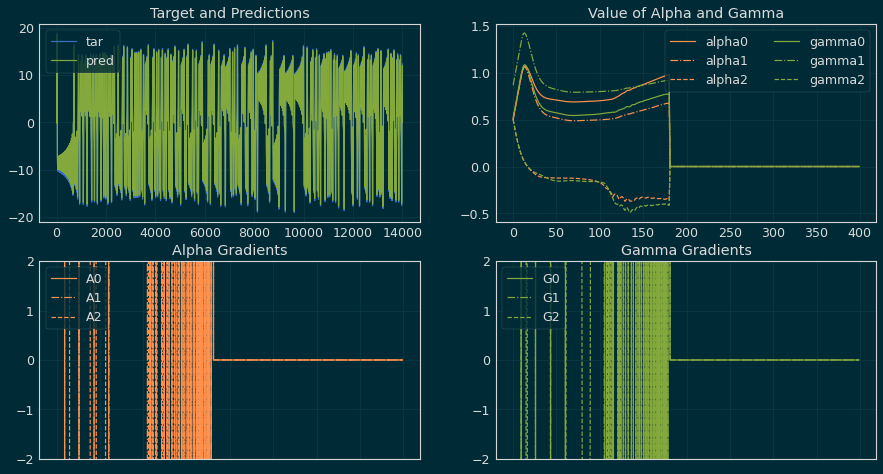

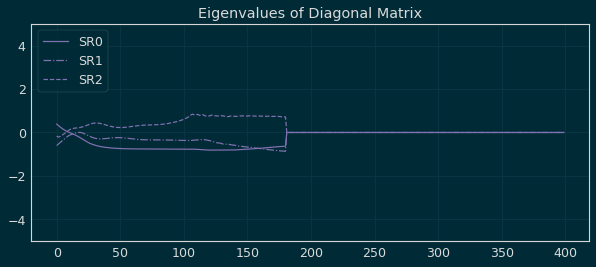

Epoch: 190


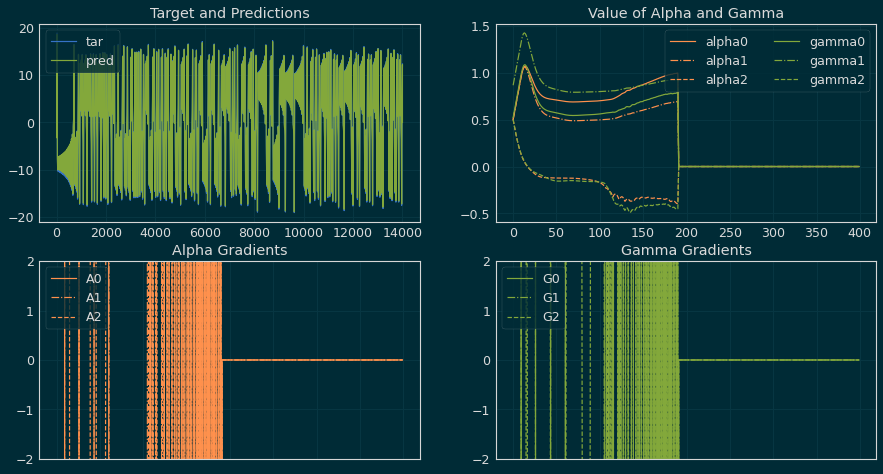

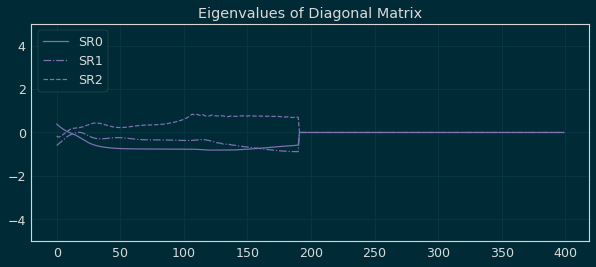

Epoch: 200


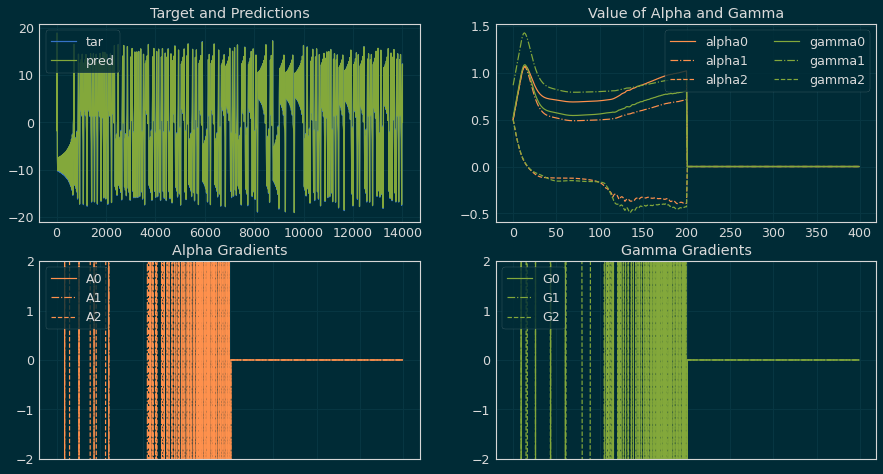

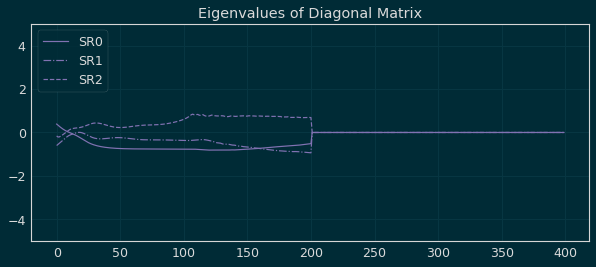

Epoch: 210


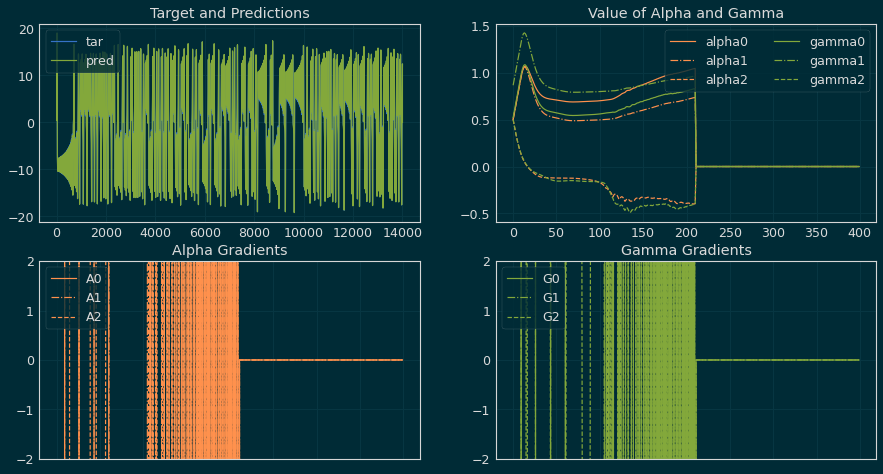

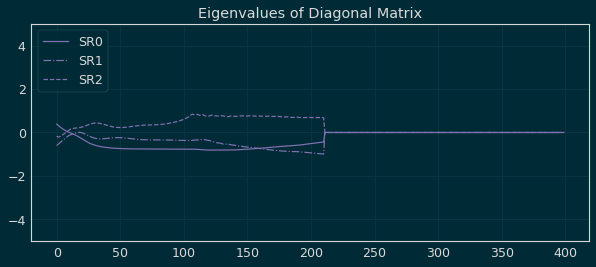

Epoch: 220


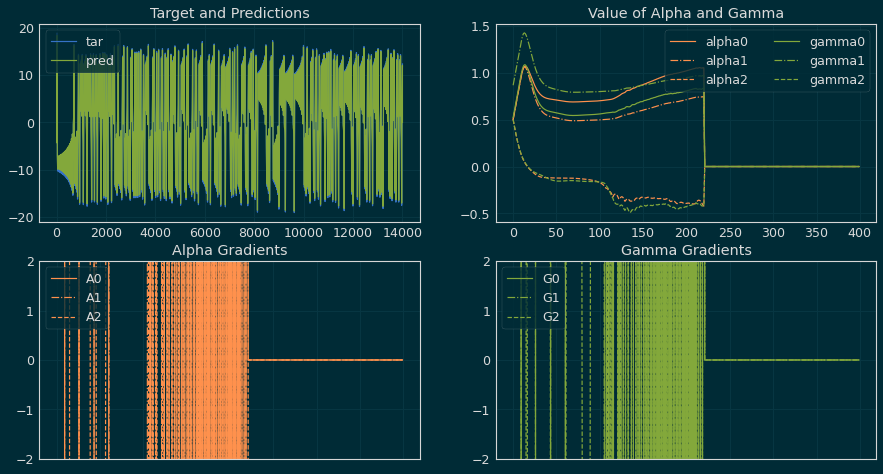

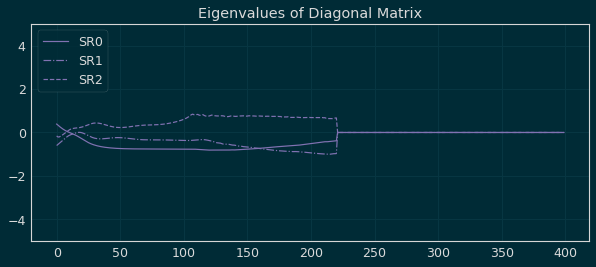

Epoch: 230


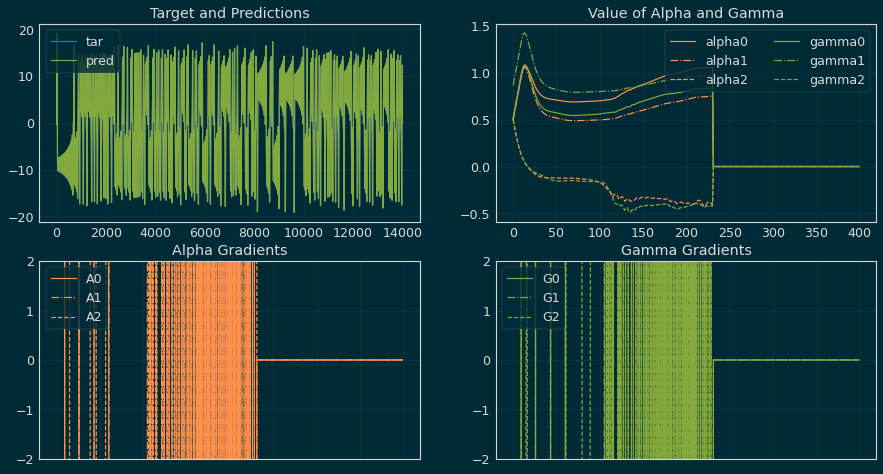

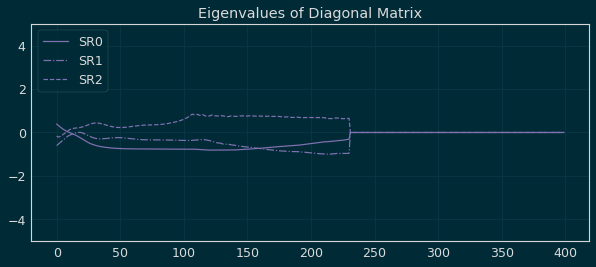

Epoch: 240


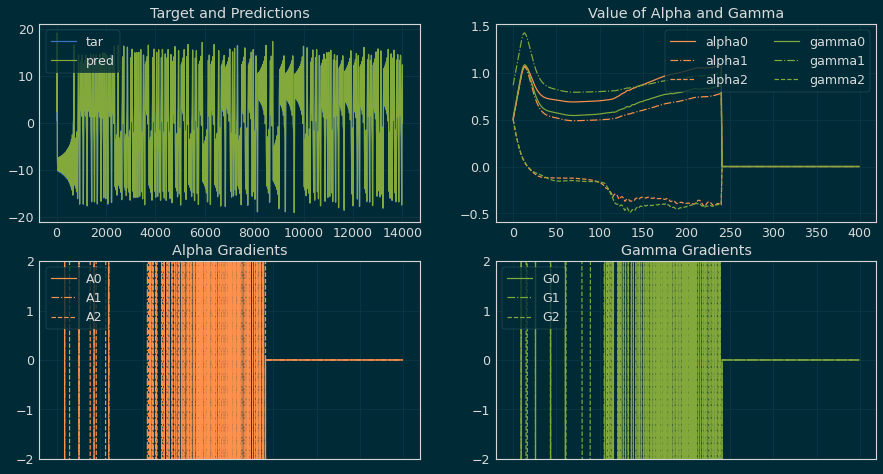

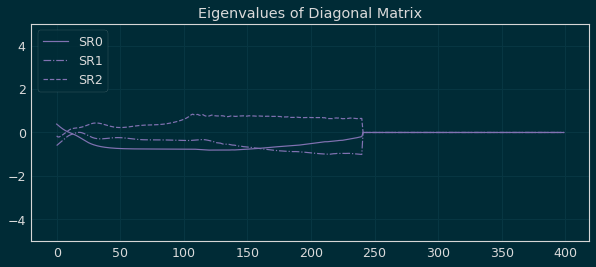

Epoch: 250


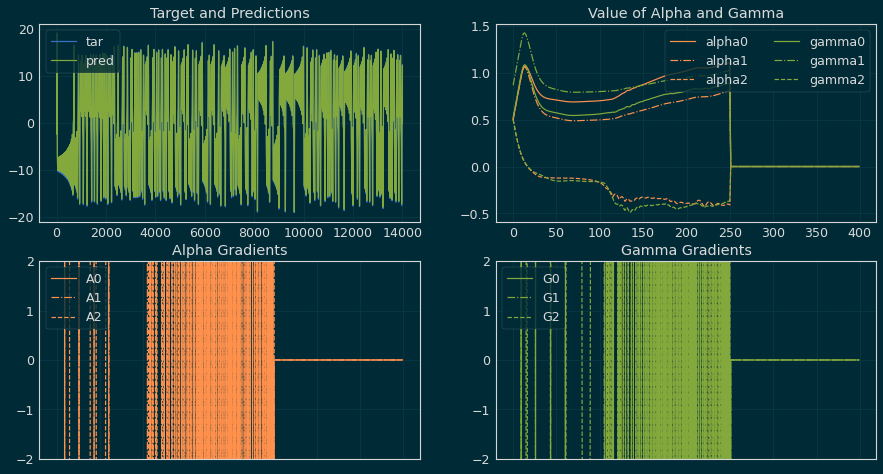

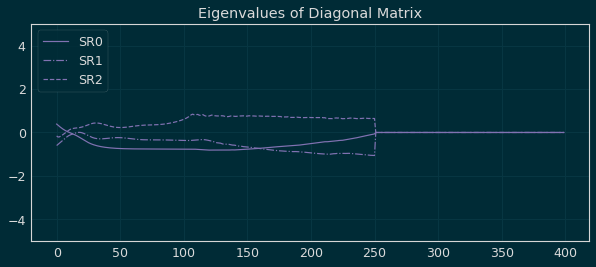

Epoch: 260


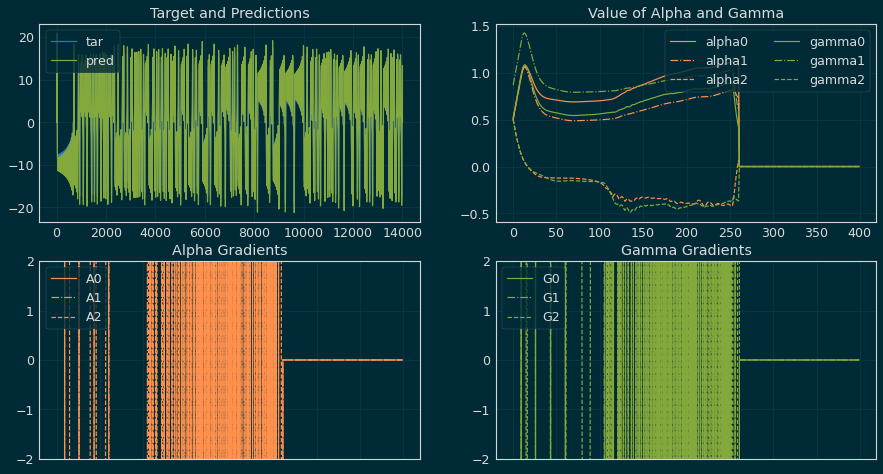

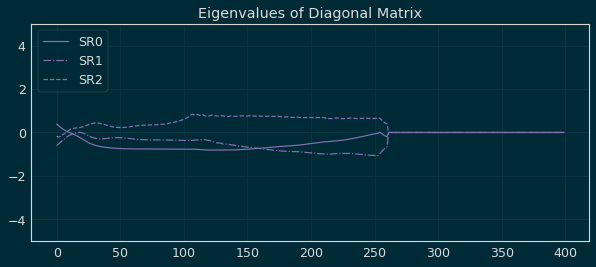

Epoch: 270


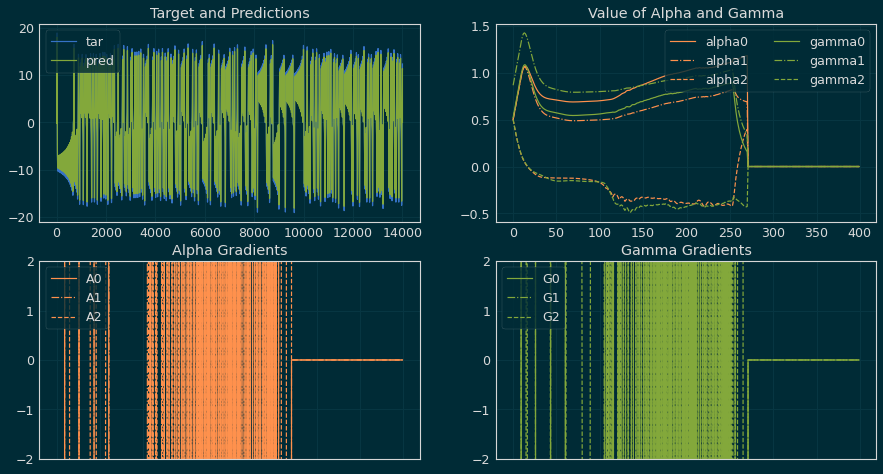

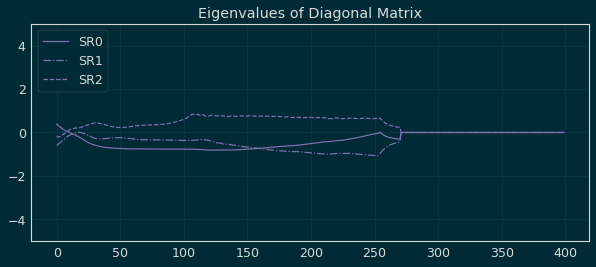

Epoch: 280


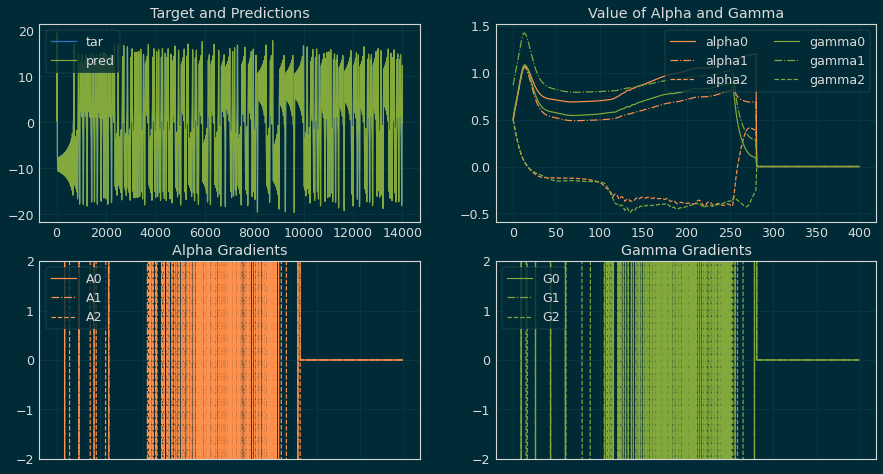

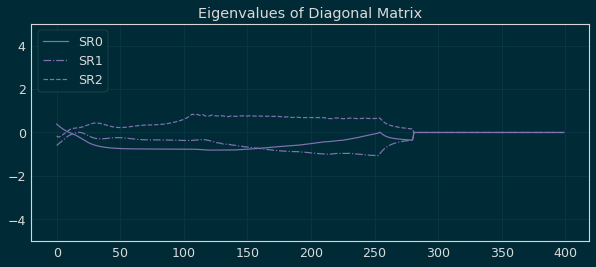

Epoch: 290


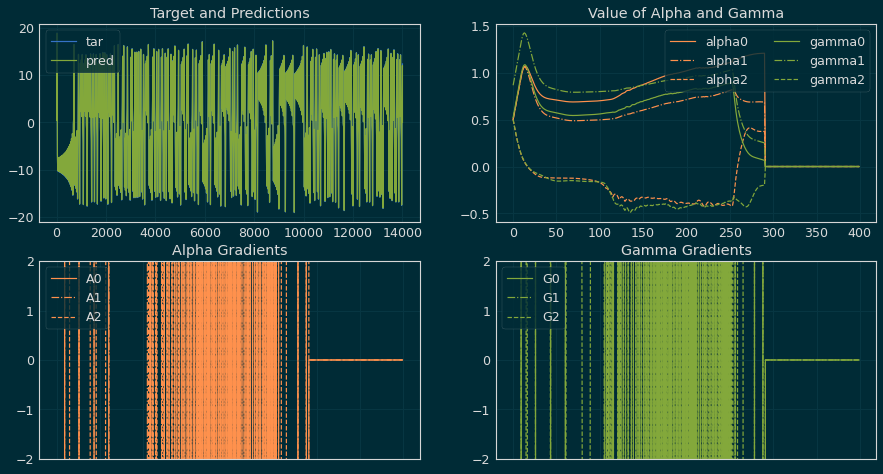

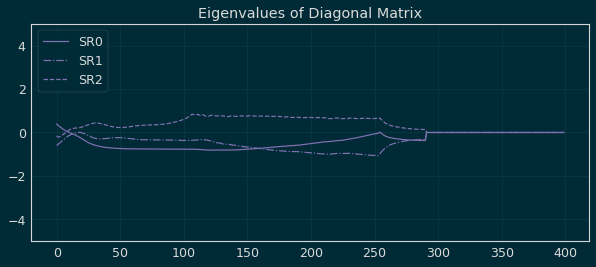

Epoch: 300


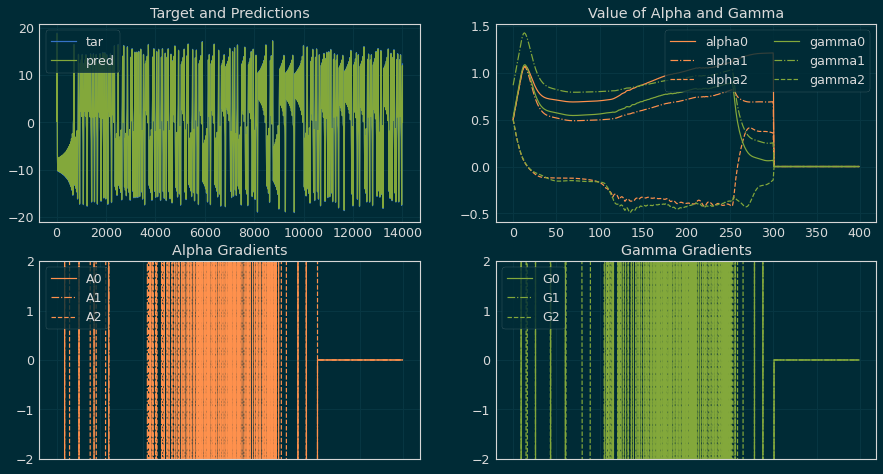

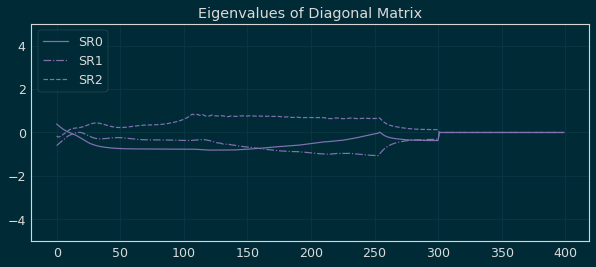

Epoch: 310


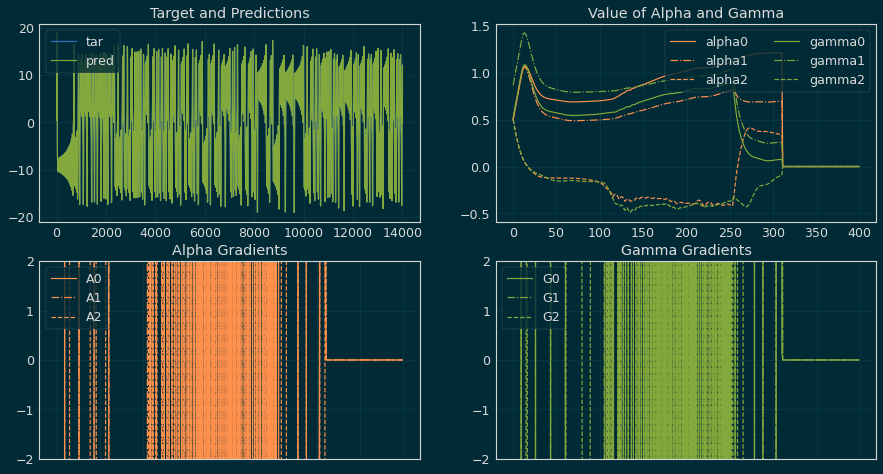

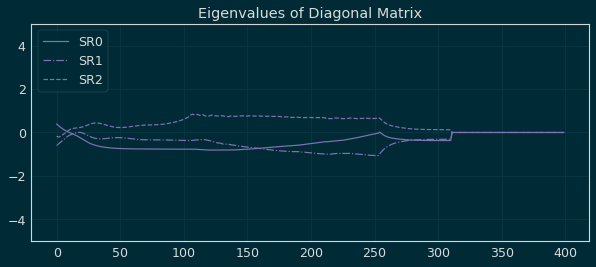

Epoch: 320


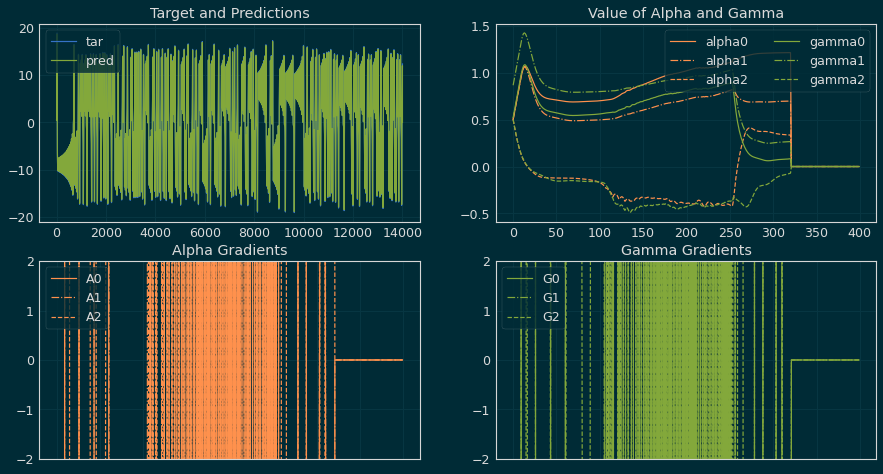

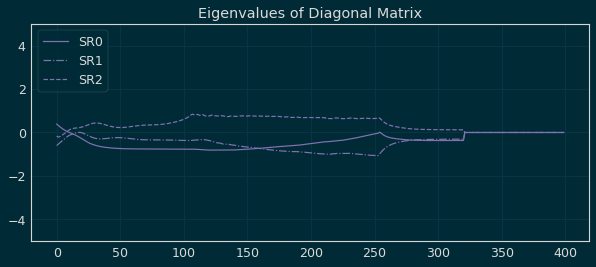

Epoch: 330


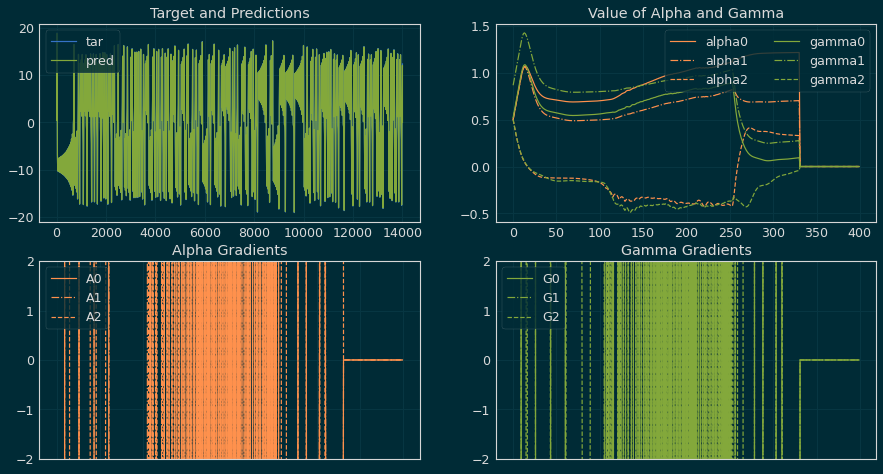

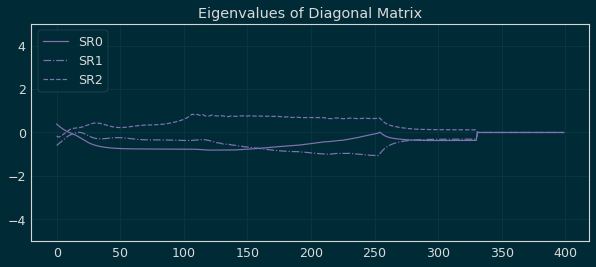

Epoch: 340


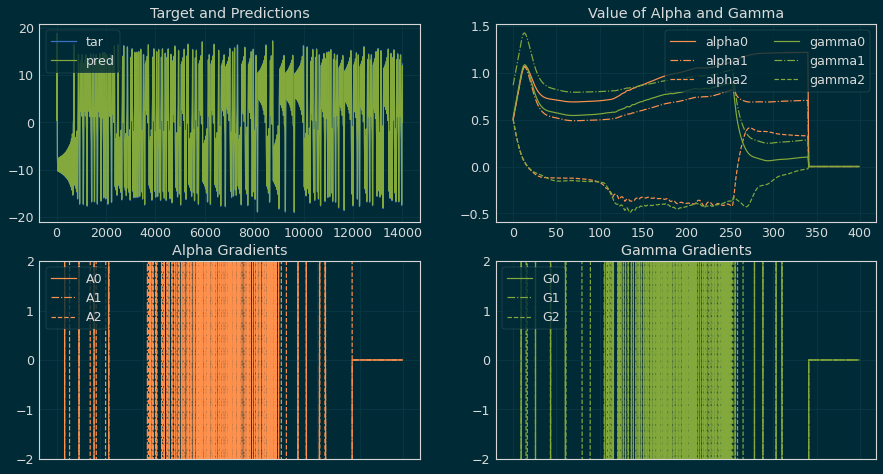

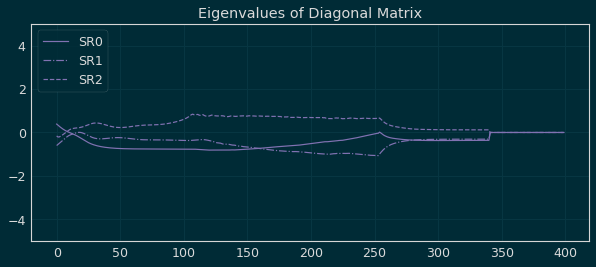

Epoch: 350


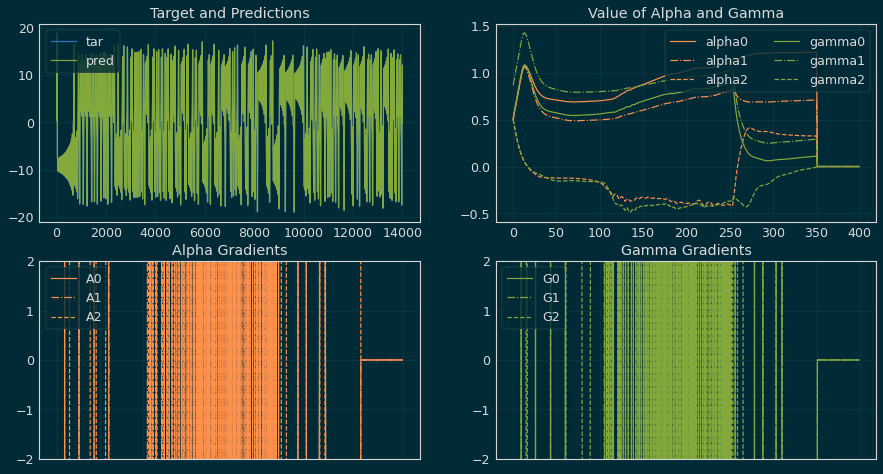

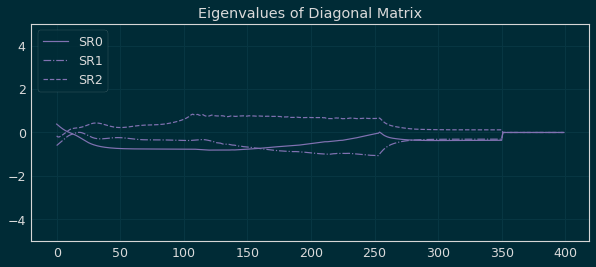

Epoch: 360


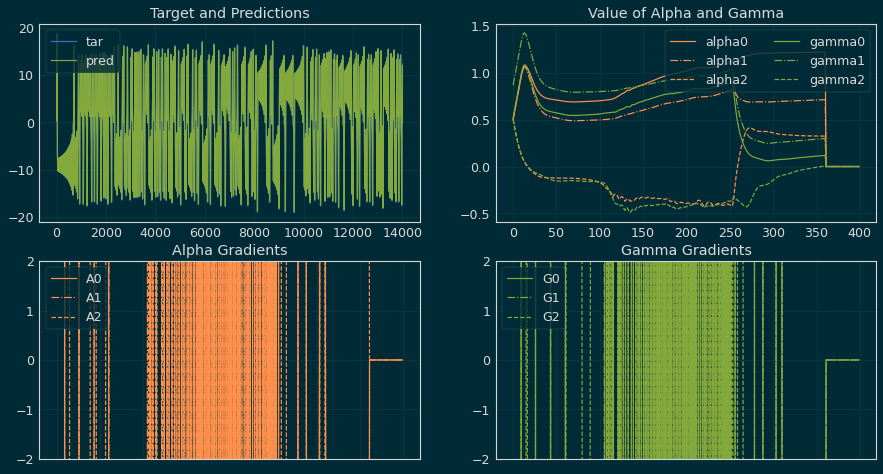

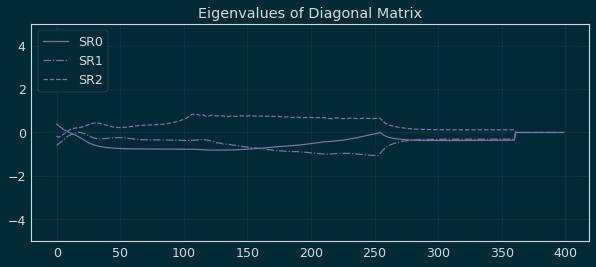

Epoch: 370


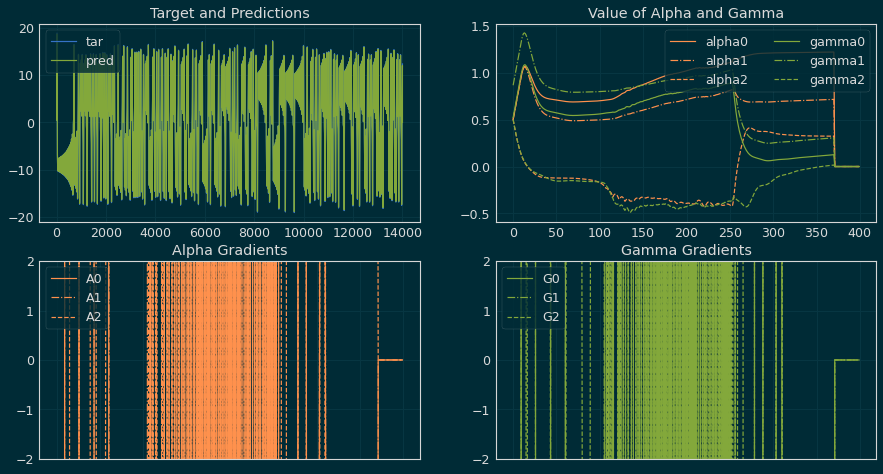

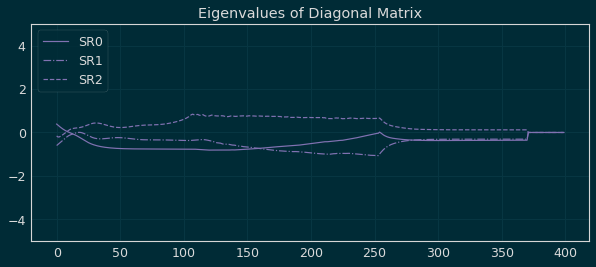

Epoch: 380


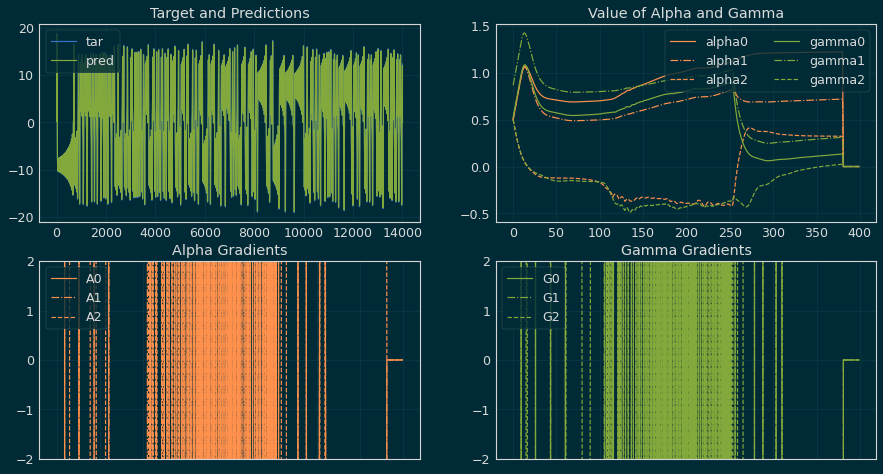

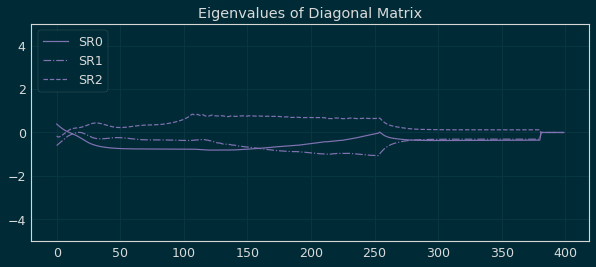

Epoch: 390


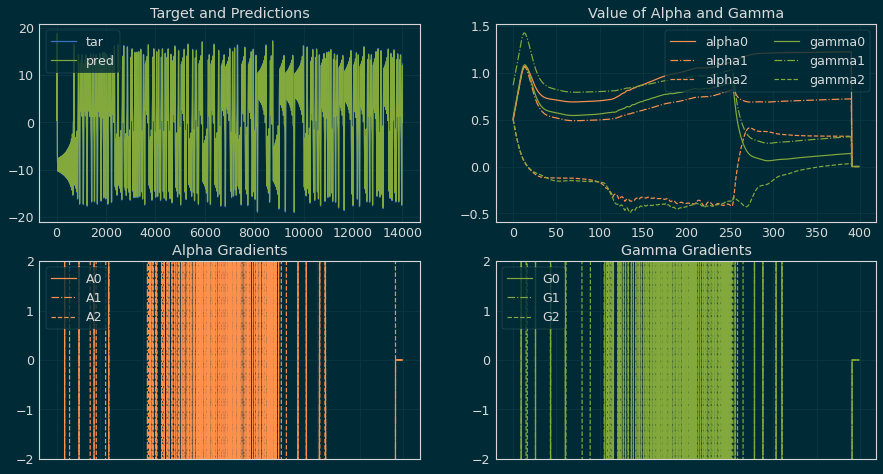

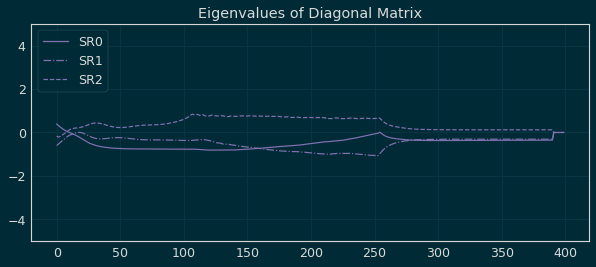

In [11]:
EPOCHS = 400
alphas = np.zeros((EPOCHS,3))
gammas = np.zeros((EPOCHS,3))
eigs = np.zeros((EPOCHS,3))
Agrad = np.zeros((EPOCHS,3))
Ggrad = np.zeros((EPOCHS,3))
SR = np.zeros((EPOCHS,3))
for ep in range(400):
    preds = np.zeros(TRAIN)
    xt = esn.packState()
    loss = 0.
    optimizer.zero_grad()
    for i in range(Tl-1):
        ut = torch.Tensor([[signal[i]]])
        y = torch.Tensor([[signal[i+1]]])
        xt1, yhat = esn(xt,ut)
        loss += criterion(yhat,y)
        preds[i] = yhat.detach().numpy()[0,0]
        xt = xt1
    loss.backward()
    eigs[ep] = esn.D.data[:]
    alphas[ep] = esn.Lky.a.data[:]
    gammas[ep] = esn.Lky.g.data[:]
    Agrad[ep] = np.array([np.squeeze(l.detach().numpy()) for l in  esn.Lky.aGrad_list])[-1]
    Ggrad[ep] = np.array([np.squeeze(l.detach().numpy()) for l in  esn.Lky.gGrad_list])[-1]
    SR[ep] = esn.D.data[:]
    optimizer.step()
    esn.clearList()
   
    if(ep%10==0):
        print(f'Epoch: {ep}')
        target = signal[:Tl]
        plt.figure(figsize=(15,8))

        ax1 = plt.subplot(221)
        ax1.set_title('Target and Predictions')
        ax1.plot(target, label='tar')
        ax1.plot(preds, label='pred')
        ax1.legend(loc='upper left')

        ax2 = plt.subplot(222)
        ax2.set_title('Value of Alpha and Gamma')
        ax2.plot(alphas[:,0],'y-', label='alpha0')
        ax2.plot(alphas[:,1],'y', linestyle='dashdot', label='alpha1')
        ax2.plot(alphas[:,2],'y--',marker='x', label='alpha2')
        ax2.plot(gammas[:,0],'g-', label='gamma0')
        ax2.plot(gammas[:,1],'g', linestyle='dashdot', label='gamma1')
        ax2.plot(gammas[:,2],'g--',marker='x', label='gamma2')
        ax2.legend(loc='upper right',ncol=2)

        ax3 = plt.subplot(223)
        ax3.set_title('Alpha Gradients')
        ax3.plot(Agrad[:,0],'y-', label='A0')
        ax3.plot(Agrad[:,1],'y', linestyle='dashdot', label='A1')
        ax3.plot(Agrad[:,2],'y--', marker='x', label='A2')
        ax3.set_xticklabels([])
        ax3.set_ylim(-2,2)
        ax3.legend(loc='upper left')
        
        ax4 = plt.subplot(224)
        ax4.set_title('Gamma Gradients')
        ax4.plot(Ggrad[:,0],'g-', label='G0')
        ax4.plot(Ggrad[:,1],'g', linestyle='dashdot', label='G1')
        ax4.plot(Ggrad[:,2],'g--', marker='x', label='G2')
        ax4.set_xticklabels([])
        ax4.set_ylim(-2,2)
        ax4.legend(loc='upper left')
        plt.show()
        plt.close()
        
        plt.figure(figsize=(10,4))
        plt.title('Eigenvalues of Diagonal Matrix')
        plt.plot(SR[:,0],'m-', label='SR0')
        plt.plot(SR[:,1],'m', linestyle='dashdot', label='SR1')
        plt.plot(SR[:,2],'m--', marker='x', label='SR2')
        plt.ylim(-5,5)
        plt.legend(loc='upper left')
        plt.show()
        plt.close()
        

In [12]:
SR[-1,:]

array([-0.35021445, -0.30988914,  0.12384018])

In [13]:
alphas[-1,:]

array([1.22311354, 0.72332275, 0.32130945])

In [14]:
gammas[-1,:]

array([0.14530456, 0.3239142 , 0.03666973])